In [4]:
!pip install -U ultralytics albumentations ipywidgets pyyaml

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.4/904.4 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.16
    Uninstalling albucore-0.0.16:
      Successfully uninstalled albucore-0.0.16
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.15
    Uninstalling albumentations-1.4.15:
      Successfully uninstalled albumentations-1.4.15


### **import libraries**

In [5]:
import os
import shutil
import random
from pathlib import Path
import yaml
from itertools import product
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import albumentations as A
from ultralytics import YOLO
from sklearn.model_selection import KFold
from collections import Counter

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
df = pd.read_csv('/kaggle/input/mias-mammography/Info.txt', sep='\s+')

In [7]:
df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [8]:
df['CLASS'] = df['CLASS'].apply(lambda x : 'MASS' if x in ['CIRC','SPIC', 'MISC'] else x)

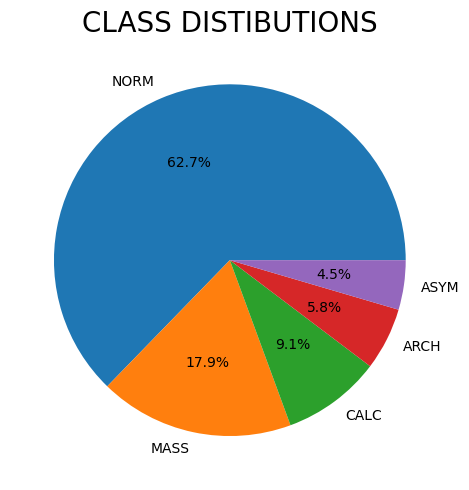

In [9]:
# Define labels as the unique classes
labels = df['CLASS'].value_counts().index.tolist()

# Plot pie chart
plt.figure(figsize=(8, 5), edgecolor='black')
plt.pie(
    df['CLASS'].value_counts(), 
    labels=labels, 
    autopct='%1.1f%%', 
    textprops={'fontsize': 10}
)
plt.title('CLASS DISTIBUTIONS', fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
df = df.drop(df[(df['CLASS'] != 'NORM') & (df['X'].isnull())].index)
df = df.fillna(0)

# Calculate height and width (2 * RADIUS for both)
df['WIDTH'] = df['RADIUS'] * 2
df['HEIGHT'] = df['RADIUS'] * 2

#label encoding
df['CLASS'] = df['CLASS'].map({'NORM':0 , 'CALC':1, 'MASS':2, 'ARCH':3, 'ASYM':4})

In [11]:
df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,WIDTH,HEIGHT
0,mdb001,G,2,B,535.0,425.0,197.0,394.0,394.0
1,mdb002,G,2,B,522.0,280.0,69.0,138.0,138.0
2,mdb003,D,0,0,0.0,0.0,0.0,0.0,0.0
3,mdb004,D,0,0,0.0,0.0,0.0,0.0,0.0
4,mdb005,F,2,B,477.0,133.0,30.0,60.0,60.0


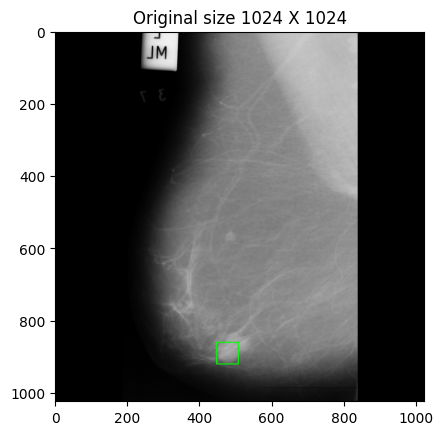

In [9]:
width = 1024
height = 1024

# Load the image
image = cv2.imread('/kaggle/input/mias-mammography/all-mias/mdb005.pgm')

# Define the bounding box in (x_center, y_center, width, height)
x_center = 477
y_center = height - 133 # Coordinate system origin is the bottom-left corner. (convert it to be top-left)
width = 30
height = 30

# Calculate top-left and bottom-right coordinates
x_min = int(x_center - width)
y_min = int(y_center - height)
x_max = int(x_center + width)
y_max = int(y_center + height)

# Draw the bounding box on the image
color = (0, 255, 0)  # Green color in BGR
thickness = 2
cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

# Display the image
plt.title('Original size 1024 X 1024')
plt.imshow(image)

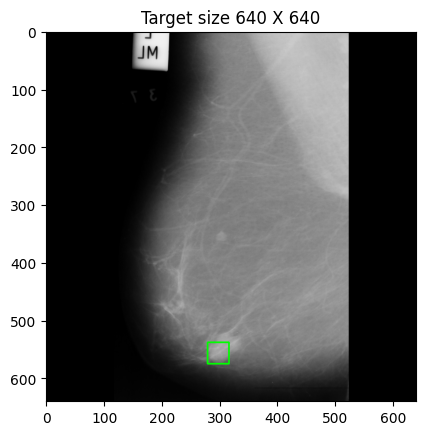

In [10]:
width = 640
height = 640
resize_factor = 0.625  #resize_factor is (target size / original size) : (640 / 1024) = 0.625

# Load the image
image = cv2.imread('/kaggle/input/mias-mammography/all-mias/mdb005.pgm')
image = cv2.resize(image,(640,640))

# Define the bounding box in (x_center, y_center, width, height)
x_center = 477 * resize_factor
y_center = height - 133 * resize_factor # Coordinate system origin is the bottom-left corner. (convert it to be top-left)
width = 30
height = 30

# Calculate top-left and bottom-right coordinates
# resize the box to be half it's original size as we resize the image
x_min = int(x_center - width * resize_factor)
y_min = int(y_center - height * resize_factor)
x_max = int(x_center + width * resize_factor)
y_max = int(y_center + height * resize_factor)

# Draw the bounding box on the image
color = (0, 255, 0)  # Green color in BGR
thickness = 2
cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

# Display the image
plt.title('Target size 640 X 640')
plt.imshow(image)

### **Prepare data to fit yolov8 structure**

In [12]:
(Path("dataset") / "images").mkdir(parents=True, exist_ok=True)
(Path("dataset") / "labels").mkdir(parents=True, exist_ok=True)

In [13]:
width = 640
height = 640
resize_factor = 0.625  #resize_factor is (target size / original size) : (640 / 1024) = 0.625

for row in df.itertuples(index=False):  # Set index=False to exclude the index
    REFNUM, BG, CLASS, SEVERITY, X, Y, RADIUS, WIDTH, HEIGHT = row
    image_path = f'/kaggle/input/mias-mammography/all-mias/{REFNUM}.pgm'
   
    #read image
    image = cv2.imread(image_path)
    
    # resize
    image = cv2.resize(image,(width,height))

    #bluring
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    #Invertion_image
    image = tf.math.subtract(tf.reduce_max(image), image)
    image = image.numpy()

    # save image with preprocessing in directory (images)
    cv2.imwrite(f'dataset/images/{REFNUM}.png',image)

    with open(f'dataset/labels/{REFNUM}.txt', "a") as file:

        if (X != 0) and (Y != 0):
        
            class_label = CLASS
            
            X = X * resize_factor
            Y = Y * resize_factor
            Y = height - Y # Coordinate system origin is the bottom-left corner. (convert it to be top-left)
            
            # Calculate YOLO format coordinates
            x_center_norm = X / width
            y_center_norm = Y / height
            w_norm = WIDTH / width
            h_norm = HEIGHT / height
            
            annotation = f"{class_label} {x_center_norm:.6f} {y_center_norm:.6f} {w_norm:.6f} {h_norm:.6f} \n"
        else :
            annotation = ''
        # save annotation in directory (labels)
        file.write(annotation)

### **Augmentation**

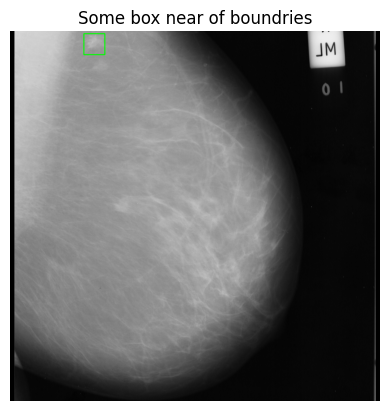

In [185]:
width = 1024
height = 1024

# Load the image
image = cv2.imread('/kaggle/input/mias-mammography/all-mias/mdb144.pgm')

# Define the bounding box in (x_center, y_center, width, height)
x_center = 233
y_center = height - 988 # Coordinate system origin is the bottom-left corner. (convert it to be top-left)
width = 58
height = 58

# Calculate top-left and bottom-right coordinates
x_min = int(x_center - width/2)
y_min = int(y_center - height/2)
x_max = int(x_center + width/2)
y_max = int(y_center + height/2)

# Draw the bounding box on the image
color = (0, 255, 0)  # Green color in BGR
thickness = 2
cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

# Display the image
plt.title('Some box near of boundries')
plt.axis('off')
plt.imshow(image)

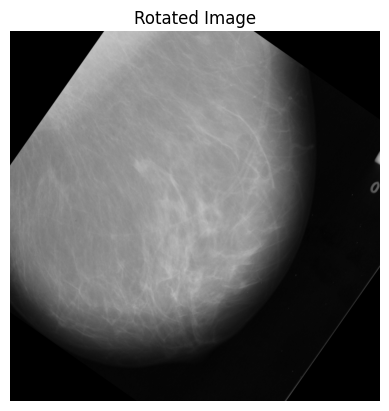

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/kaggle/input/mias-mammography/all-mias/mdb144.pgm')  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

# Define the rotation angle and center
angle = -35  # Angle in degrees
(h, w) = image.shape[:2]
center = (w // 2, h // 2)

# Get the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Perform the rotation
rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))

# Display the rotated image
plt.imshow(rotated_image)
plt.axis('off')
plt.title('Rotated Image')
plt.show()


In [14]:
# Define augmentation pipeline
augmentation = A.Compose([
    A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), p=0.5),  # Randomly crop between 80% and 100% of the image
    A.Rotate(limit=15, p=1.0),  # Random rotation between -15 and +15 degrees
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.1),
], bbox_params=A.BboxParams(format='yolo',
    min_visibility=0.5))

# Directory paths
image_dir = 'dataset/images'  # Directory with original images
label_dir = 'dataset/labels'  # Directory with corresponding label files in YOLO format

# Number of augmented images to generate per original image
num_augmentations = 1

# Iterate over images in the directory
for image_name in os.listdir(image_dir):
    if image_name.endswith('.png'):  # Adjust image extension as needed
        # Read the image
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        # Read the corresponding label file
        label_path = os.path.join(label_dir, image_name.replace('.png', '.txt'))
        with open(label_path, 'r') as file:
            bboxes = []
            for line in file:
                line = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, line)
                if (y_center >= height) and (x_center >= width):                  # this condition to prevent box out of boundries
                    bboxes.append([x_center, y_center, width, height, class_id])
                else :
                    continue
        # Generate multiple augmentations
        for i in range(num_augmentations):
            # Apply augmentation
            augmented = augmentation(image=image, bboxes=bboxes)
            aug_image, aug_bboxes = augmented['image'], augmented['bboxes']
            for bbox in aug_bboxes:
                # Save the augmented image
                aug_image_path = os.path.join(image_dir, f"{image_name.replace('.png', '')}_aug_{i + 1}.png")
                cv2.imwrite(aug_image_path, aug_image)

                # Save the augmented label file
                aug_label_path = os.path.join(label_dir, f"{image_name.replace('.png', '')}_aug_{i + 1}.txt")
                with open(aug_label_path, 'w') as file:
                    for bbox in aug_bboxes:
                        file.write(f"{int(bbox[4])} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

print("Processing complete. Augmented images and labels saved.")


Processing complete. Augmented images and labels saved.


In [15]:
class_label = []
for dir, _, filenames in os.walk('/kaggle/working/dataset/labels'):
    for filename in filenames:
        with open(os.path.join(dir,filename), 'r') as file:
            file = file.readline()
            if file == '':
                class_label.append('0')
            else:
                file = file.split()
                class_label.append(file[0])

In [16]:
# Get value counts
counts = Counter(class_label)

# Print the result
print(counts)

Counter({'0': 207, '2': 103, '1': 44, '3': 38, '4': 30})


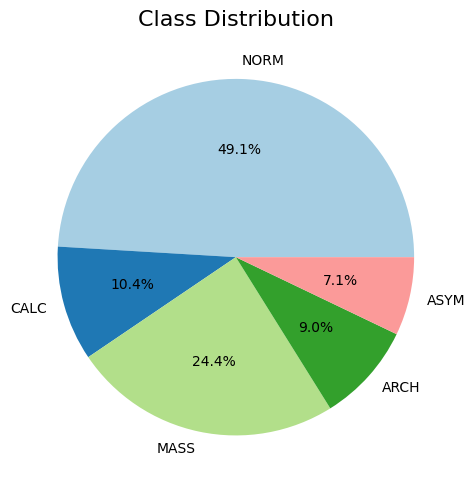

In [17]:
# Pie Chart
plt.figure(figsize=(8, 5))
labels = counts.keys()
# Create a mapping for the labels
label_mapping = {'0': 'NORM', '1': 'CALC', '2': 'MASS', '3': 'ARCH', '4': 'ASYM'}
# Generate the labels using the mapping
labels = [label_mapping[key] for key in counts.keys()]
plt.pie(
    counts.values(), 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=0, 
    colors=plt.cm.Paired.colors, 
    textprops={'fontsize': 10}
)
plt.title('Class Distribution', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# Paths to the original dataset
images_dir = "dataset/images"  # Path to images directory
labels_dir = "dataset/labels"  # Path to labels directory

# Target directories for splits
output_dirs = {
    "train": {"images": "dataset_holdout/train/images", "labels": "dataset_holdout/train/labels"},
    "val": {"images": "dataset_holdout/val/images", "labels": "dataset_holdout/val/labels"},
    "test": {"images": "dataset_holdout/test/images", "labels": "dataset_holdout/test/labels"}
}

# Create target directories if they don't exist
for split, paths in output_dirs.items():
    for path in paths.values():
        os.makedirs(path, exist_ok=True)

# Define split ratios (train, val, test)
train_ratio = 0.8
test_ratio = 0.2

# Gather all image files (assumes images and labels have the same base names)
image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]
random.shuffle(image_files)

# Calculate split sizes
total_images = len(image_files)
train_count = int(total_images * train_ratio)
test_count = total_images - train_count   # Remaining images for test split

# Split dataset
splits = {
    "train": image_files[:train_count],
    "test": image_files[train_count :]
}

# Copy files to corresponding directories
for split, files in splits.items():
    for file in files:
        # Copy image
        src_image_path = os.path.join(images_dir, file)
        dest_image_path = os.path.join(output_dirs[split]["images"], file)
        shutil.copy(src_image_path, dest_image_path)

        # Copy label (assumes label file has same base name as image)
        file = Path(file)
        label_file = file.with_suffix(".txt")
        src_label_path = os.path.join(labels_dir, label_file)
        dest_label_path = os.path.join(output_dirs[split]["labels"], label_file)
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dest_label_path)

print("Dataset split and files copied successfully!")


Dataset split and files copied successfully!


In [19]:
# Define the data for the YAML file
data = {
    'path': '/kaggle/working/dataset_holdout',
    'names': {0:'NORM', 1:'CALC', 2:'MASS', 3:'ARCH', 4:'ASYM'},
    'nc': 5,
    'train': 'train',
    'val': 'val',
    'test': 'test'
}

# Save the data to a YAML file
with open('dataset_holdout/data.yaml', 'w') as file:
    yaml.dump(data, file)

print("data.yaml file created!")


data.yaml file created!


In [20]:
# 1. Setup and get labels
dataset_path = Path("dataset_holdout/train")  # replace with 'path/to/dataset' for your custom data
labels = sorted(dataset_path.rglob("*labels/*.txt"))  # all data in 'labels'

# 2. Read YAML and create feature vectors
yaml_file = "dataset_holdout/data.yaml"  # your data YAML with data directories and names dictionary
with open(yaml_file, "r", encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]
cls_idx = sorted(classes.keys())

# Initialize DataFrame
indx = [label.stem for label in labels]
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

# Count instances
for label in labels:
    lbl_counter = Counter()
    with open(label, "r") as lf:
        lines = lf.readlines()
    for line in lines:
        lbl_counter[int(line.split(" ")[0])] += 1
    labels_df.loc[label.stem] = lbl_counter
labels_df = labels_df.fillna(0.0)

# 3. Create k-fold splits
ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)
kfolds = list(kf.split(labels_df))

# 4. Create fold directories
folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)
for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f"split_{idx}"].loc[labels_df.iloc[train].index] = "train"
    folds_df[f"split_{idx}"].loc[labels_df.iloc[val].index] = "val"

# 5. Setup directories and YAML files
supported_extensions = [".jpg", ".jpeg", ".png"]
images = []
for ext in supported_extensions:
    images.extend(sorted((dataset_path / "images").rglob(f"*{ext}")))

save_path = Path(f"/kaggle/working/{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)

ds_yamls = []
for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)
    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )
# 6. Copy images and labels to respective directories
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [24]:
# Define grid search parameters
batch_sizes = [8, 16]
epochs = [100, 150]

# Create all combinations of hyperparameters
grid = list(product(batch_sizes, epochs))

# Path to your initial weights
weights_path = "yolov8n.pt"

# Perform grid search
for batch, ep in grid:
    print(f"batch_size={batch}, epochs={ep}")

    # Loop over each fold
    for k, dataset_yaml in enumerate(ds_yamls):
        print(f"Training on fold {k+1}")

        # Initialize YOLO model
        model = YOLO(weights_path, task="detect")

        # Train model with the current combination of hyperparameters
        model.train(
            data=dataset_yaml,
            epochs=ep,
            batch=batch,
            project="kfold_gridsearch",
            name=f"fold{k+1}_batch{batch}_epochs{ep}",
            patience = 10
        )


batch_size=8, epochs=5
Training on fold 1


100%|██████████| 6.25M/6.25M [00:00<00:00, 126MB/s]


Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/5-Fold_Cross-val/split_1/split_1_dataset.yaml, epochs=5, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=kfold_gridsearch_edit_large, name=fold1_batch8_epochs5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fal

100%|██████████| 755k/755k [00:00<00:00, 27.1MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/5-Fold_Cross-val/split_1/train/labels... 269 images, 135 backgrounds, 0 corrupt: 100%|██████████| 269/269 [00:00<00:00, 654.94it/s]


train: New cache created: /kaggle/working/5-Fold_Cross-val/split_1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/5-Fold_Cross-val/split_1/val/labels... 68 images, 30 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<00:00, 345.82it/s]

val: New cache created: /kaggle/working/5-Fold_Cross-val/split_1/val/labels.cache


Plotting labels to kfold_gridsearch_edit_large/fold1_batch8_epochs5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to kfold_gridsearch_edit_large/fold1_batch8_epochs5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       1.3G       2.98      8.565      2.495          4        640: 100%|██████████| 34/34 [00:05<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all         68         40   0.000181     0.0938    0.00238   0.000578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.26G      2.666       8.15      2.355          4        640: 100%|██████████| 34/34 [00:03<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68         40   0.000647      0.198     0.0461     0.0131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.26G      2.448        6.6      2.196          6        640: 100%|██████████| 34/34 [00:03<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68         40       0.79     0.0156     0.0148     0.0053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.26G       2.38      6.724      2.197          6        640: 100%|██████████| 34/34 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68         40      0.811     0.0469     0.0379     0.0146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.26G      2.036      6.586      1.882          3        640: 100%|██████████| 34/34 [00:04<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68         40      0.825     0.0469     0.0455     0.0185



5 epochs completed in 0.009 hours.
Optimizer stripped from kfold_gridsearch_edit_large/fold1_batch8_epochs5/weights/last.pt, 6.2MB
Optimizer stripped from kfold_gridsearch_edit_large/fold1_batch8_epochs5/weights/best.pt, 6.2MB

Validating kfold_gridsearch_edit_large/fold1_batch8_epochs5/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


                   all         68         40      0.828     0.0469      0.045     0.0183
                  CALC          8         10          1          0          0          0
                  MASS         16         16      0.312      0.188      0.124     0.0527
                  ARCH          8          8          1          0     0.0191    0.00703
                  ASYM          6          6          1          0     0.0371     0.0134
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to kfold_gridsearch_edit_large/fold1_batch8_epochs5
Training on fold 2
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/5-Fold_Cross-val/split_2/split_2_dataset.yaml, epochs=5, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=kfold_gridsearch_edit_large, name=fold2_b

train: Scanning /kaggle/working/5-Fold_Cross-val/split_2/train/labels... 269 images, 130 backgrounds, 0 corrupt: 100%|██████████| 269/269 [00:00<00:00, 636.33it/s]

train: New cache created: /kaggle/working/5-Fold_Cross-val/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/5-Fold_Cross-val/split_2/val/labels... 68 images, 35 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<00:00, 548.97it/s]

val: New cache created: /kaggle/working/5-Fold_Cross-val/split_2/val/labels.cache


Plotting labels to kfold_gridsearch_edit_large/fold2_batch8_epochs5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to kfold_gridsearch_edit_large/fold2_batch8_epochs5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.35G      3.017      8.734       2.56          3        640: 100%|██████████| 34/34 [00:04<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68         36   0.000359      0.153     0.0071    0.00196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.26G      2.523      8.001      2.233          2        640: 100%|██████████| 34/34 [00:03<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68         36   0.000332      0.188    0.00243   0.000709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.26G       2.56      7.109       2.23          5        640: 100%|██████████| 34/34 [00:03<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68         36   9.35e-05     0.0294   0.000858   0.000351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       1.2G      2.369      7.152      2.086          9        640: 100%|██████████| 34/34 [00:03<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68         36   0.000325      0.118    0.00389    0.00201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.26G      2.278      7.113      1.957          4        640: 100%|██████████| 34/34 [00:03<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68         36      0.812     0.0441     0.0567     0.0229



5 epochs completed in 0.019 hours.
Optimizer stripped from kfold_gridsearch_edit_large/fold2_batch8_epochs5/weights/last.pt, 6.2MB
Optimizer stripped from kfold_gridsearch_edit_large/fold2_batch8_epochs5/weights/best.pt, 6.2MB

Validating kfold_gridsearch_edit_large/fold2_batch8_epochs5/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


                   all         68         36      0.813     0.0441     0.0569      0.023
                  CALC          6          8          1          0          0          0
                  MASS         16         17      0.253      0.176      0.211     0.0855
                  ARCH          5          5          1          0    0.00587    0.00286
                  ASYM          6          6          1          0      0.011    0.00373
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to kfold_gridsearch_edit_large/fold2_batch8_epochs5
Training on fold 3
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/5-Fold_Cross-val/split_3/split_3_dataset.yaml, epochs=5, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=kfold_gridsearch_edit_large, name=fold3_b

train: Scanning /kaggle/working/5-Fold_Cross-val/split_3/train/labels... 270 images, 131 backgrounds, 0 corrupt: 100%|██████████| 270/270 [00:00<00:00, 587.51it/s]

train: New cache created: /kaggle/working/5-Fold_Cross-val/split_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/5-Fold_Cross-val/split_3/val/labels... 67 images, 34 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 694.69it/s]

val: New cache created: /kaggle/working/5-Fold_Cross-val/split_3/val/labels.cache


Plotting labels to kfold_gridsearch_edit_large/fold3_batch8_epochs5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to kfold_gridsearch_edit_large/fold3_batch8_epochs5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       1.3G      2.986      9.129      2.695          2        640: 100%|██████████| 34/34 [00:04<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

                   all         67         35   0.000192     0.0798   0.000496   0.000133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.25G      2.681      9.924      2.382          5        640: 100%|██████████| 34/34 [00:03<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         67         35   0.000183     0.0921    0.00119   0.000153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.25G      2.561      7.135       2.11          7        640: 100%|██████████| 34/34 [00:03<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         67         35   0.000611      0.279    0.00109   0.000325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.25G      2.251      6.725      1.968          3        640: 100%|██████████| 34/34 [00:04<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         67         35      0.002      0.382      0.011    0.00342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.25G      2.207      6.412          2          6        640: 100%|██████████| 34/34 [00:04<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         67         35    0.00141      0.494     0.0167    0.00651



5 epochs completed in 0.019 hours.
Optimizer stripped from kfold_gridsearch_edit_large/fold3_batch8_epochs5/weights/last.pt, 6.2MB
Optimizer stripped from kfold_gridsearch_edit_large/fold3_batch8_epochs5/weights/best.pt, 6.2MB

Validating kfold_gridsearch_edit_large/fold3_batch8_epochs5/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]


                   all         67         35    0.00141      0.494     0.0168    0.00663
                  CALC          4          5          0          0          0          0
                  MASS         16         17    0.00294      0.882     0.0397     0.0159
                  ARCH          7          7   0.000483      0.429     0.0159    0.00613
                  ASYM          6          6    0.00224      0.667     0.0116     0.0045
Speed: 0.3ms preprocess, 4.6ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to kfold_gridsearch_edit_large/fold3_batch8_epochs5
Training on fold 4
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/5-Fold_Cross-val/split_4/split_4_dataset.yaml, epochs=5, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=kfold_gridsearch_edit_large, name=fold4_b

train: Scanning /kaggle/working/5-Fold_Cross-val/split_4/train/labels... 270 images, 132 backgrounds, 0 corrupt: 100%|██████████| 270/270 [00:00<00:00, 651.99it/s]


train: New cache created: /kaggle/working/5-Fold_Cross-val/split_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/5-Fold_Cross-val/split_4/val/labels... 67 images, 33 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 511.39it/s]

val: New cache created: /kaggle/working/5-Fold_Cross-val/split_4/val/labels.cache


Plotting labels to kfold_gridsearch_edit_large/fold4_batch8_epochs5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to kfold_gridsearch_edit_large/fold4_batch8_epochs5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.31G      3.192      10.28      2.628          6        640: 100%|██████████| 34/34 [00:04<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         67         39    0.00115      0.182     0.0173    0.00347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.25G      2.613      8.649      2.295          4        640: 100%|██████████| 34/34 [00:04<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         67         39   0.000109     0.0357   0.000228   4.16e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.24G      2.555      6.791      2.257          4        640: 100%|██████████| 34/34 [00:04<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         67         39   0.000798      0.341     0.0039   0.000933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.24G      2.431      6.899      2.199          8        640: 100%|██████████| 34/34 [00:03<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         67         39   0.000664      0.307     0.0222    0.00901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.24G        2.2      6.796      2.055          4        640: 100%|██████████| 34/34 [00:03<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         67         39      0.915     0.0536     0.0696     0.0204



5 epochs completed in 0.019 hours.
Optimizer stripped from kfold_gridsearch_edit_large/fold4_batch8_epochs5/weights/last.pt, 6.2MB
Optimizer stripped from kfold_gridsearch_edit_large/fold4_batch8_epochs5/weights/best.pt, 6.2MB

Validating kfold_gridsearch_edit_large/fold4_batch8_epochs5/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


                   all         67         39      0.913     0.0536     0.0696     0.0203
                  CALC         10         14          1          0          0          0
                  MASS         13         14      0.652      0.214      0.267     0.0759
                  ARCH          8          8          1          0    0.00178   0.000357
                  ASYM          3          3          1          0    0.00909    0.00511
Speed: 0.8ms preprocess, 3.7ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to kfold_gridsearch_edit_large/fold4_batch8_epochs5
Training on fold 5
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/5-Fold_Cross-val/split_5/split_5_dataset.yaml, epochs=5, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=kfold_gridsearch_edit_large, name=fold5_b

train: Scanning /kaggle/working/5-Fold_Cross-val/split_5/train/labels... 270 images, 132 backgrounds, 0 corrupt: 100%|██████████| 270/270 [00:00<00:00, 653.15it/s]

train: New cache created: /kaggle/working/5-Fold_Cross-val/split_5/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/5-Fold_Cross-val/split_5/val/labels... 67 images, 33 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 1300.74it/s]

val: New cache created: /kaggle/working/5-Fold_Cross-val/split_5/val/labels.cache


Plotting labels to kfold_gridsearch_edit_large/fold5_batch8_epochs5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to kfold_gridsearch_edit_large/fold5_batch8_epochs5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.31G      3.069      9.187      2.756          7        640: 100%|██████████| 34/34 [00:04<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         67         36   0.000172       0.11   0.000306   4.01e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.18G      2.499      8.784      2.262          5        640: 100%|██████████| 34/34 [00:04<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         67         36   0.000189     0.0776   0.000184   3.78e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.18G      2.579      7.361      2.203          3        640: 100%|██████████| 34/34 [00:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         67         36   0.000397      0.114   0.000673   0.000248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.18G      2.257      6.346      2.044          8        640: 100%|██████████| 34/34 [00:03<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         67         36      0.957     0.0132     0.0214    0.00619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.18G      2.263       6.48      2.109          2        640: 100%|██████████| 34/34 [00:04<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         67         36      0.544     0.0263     0.0294     0.0176



5 epochs completed in 0.019 hours.
Optimizer stripped from kfold_gridsearch_edit_large/fold5_batch8_epochs5/weights/last.pt, 6.2MB
Optimizer stripped from kfold_gridsearch_edit_large/fold5_batch8_epochs5/weights/best.pt, 6.2MB

Validating kfold_gridsearch_edit_large/fold5_batch8_epochs5/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]


                   all         67         36      0.545     0.0263     0.0293     0.0175
                  CALC         10         10          1          0          0          0
                  MASS         17         19      0.181      0.105      0.111     0.0679
                  ARCH          3          3          1          0   0.000293   0.000123
                  ASYM          4          4          0          0     0.0058     0.0021
Speed: 0.7ms preprocess, 4.0ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to kfold_gridsearch_edit_large/fold5_batch8_epochs5


In [21]:
model = YOLO('/kaggle/input/best_yolov8/tensorflow2/default/1/best.pt')

In [52]:
metrics = model.val(data='dataset_holdout/data.yaml', split='test')

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/dataset_holdout/train/labels... 337 images, 175 backgrounds, 0 corrupt: 100%|██████████| 337/337 [00:00<00:00, 666.58it/s]

val: New cache created: /kaggle/working/dataset_holdout/train/labels.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


                   all        337        173      0.988      0.979      0.989      0.864
                  CALC         33         40          1      0.918       0.97      0.799
                  MASS         71         75      0.991          1      0.995      0.877
                  ARCH         30         30      0.978          1      0.995        0.9
                  ASYM         28         28      0.985          1      0.995      0.879
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2


In [59]:
ground_truth = '/kaggle/working/runs/detect/val/val_batch1_labels.jpg'
prediction = '/kaggle/working/runs/detect/val/val_batch1_pred.jpg'

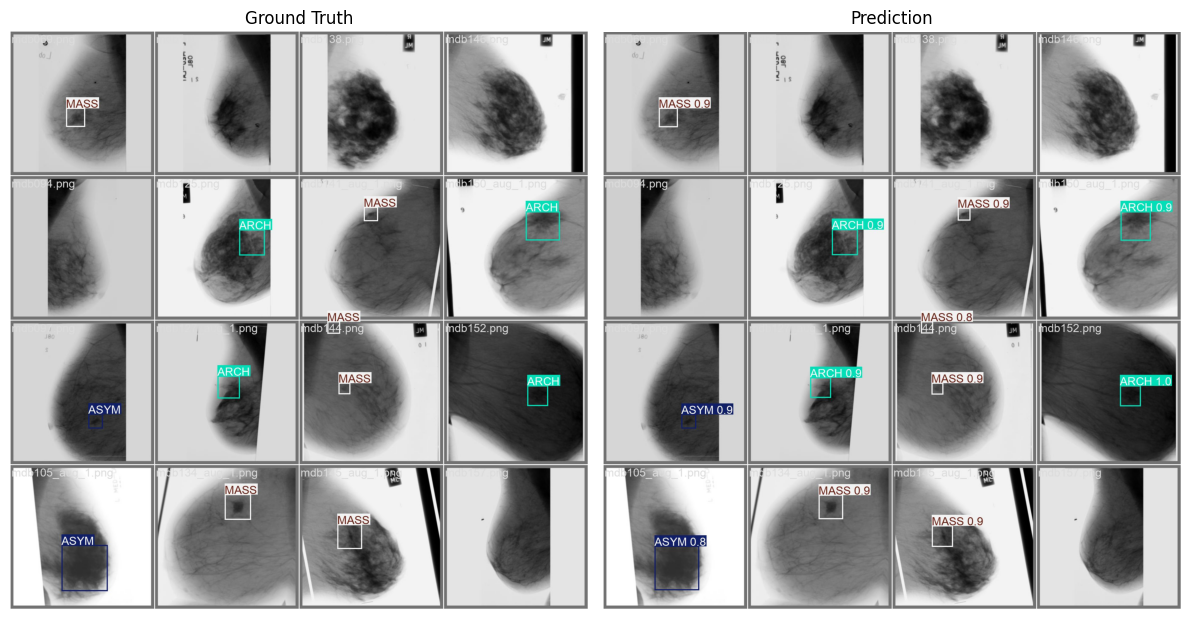

In [63]:
# Load the images
truth = cv2.imread(ground_truth)  # Replace with your ground truth image path
pred = cv2.imread(prediction)     # Replace with your prediction image path

# Convert BGR (OpenCV) to RGB (Matplotlib)
truth = cv2.cvtColor(truth, cv2.COLOR_BGR2RGB)
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 8))

# Display the ground truth image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(truth)
plt.title('Ground Truth')
plt.axis('off')  # Hide axes

# Display the prediction image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')  # Hide axes

# Show the plot
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [28]:
import os

# Directory containing the images
image_dir = '/kaggle/working/5-Fold_Cross-val/split_1/train/images'

# List of image extensions to check for
image_extensions = ('.png')

# Count the images
image_count = len([file for file in os.listdir(image_dir) if file.lower().endswith(image_extensions)])

print(f"There are {image_count} images in the directory.")


There are 269 images in the directory.
